<a href="https://colab.research.google.com/github/vaishak-krishnan/Kidney-CT-Project/blob/main/VGG_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Nov 10 00:44:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.59       Driver Version: 462.59       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  N/A |    367MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf

if tf.test.is_built_with_cuda():
    print("TensorFlow is built with CUDA")
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available")
        print("GPU Details:")
        for gpu in tf.config.list_physical_devices('GPU'):
            print(gpu)
    else:
        print("GPU is not available")
else:
    print("TensorFlow is not built with CUDA")


TensorFlow is not built with CUDA


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set")
    except RuntimeError as e:
        print(e)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tkinter import Tk, filedialog


In [ ]:
# Function to load images and masks
def load_images_and_masks(path, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)

            # Create mask (binary: 1 for Tumor, 0 for Normal)
            mask = np.ones(img_size) if 'Tumor' in path else np.zeros(img_size)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:

# Load data
tumor_path = 'C:/Tumor Normal/Tumor'
normal_path = 'C:/Tumor Normal/Normal'
tumor_images, tumor_masks = load_images_and_masks(tumor_path)
normal_images, normal_masks = load_images_and_masks(normal_path)

# Prepare data arrays
X = np.concatenate((tumor_images, normal_images), axis=0)
y = np.concatenate((tumor_masks, normal_masks), axis=0)
X = X[..., np.newaxis]  # Add channel dimension
y = y[..., np.newaxis]
y = to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


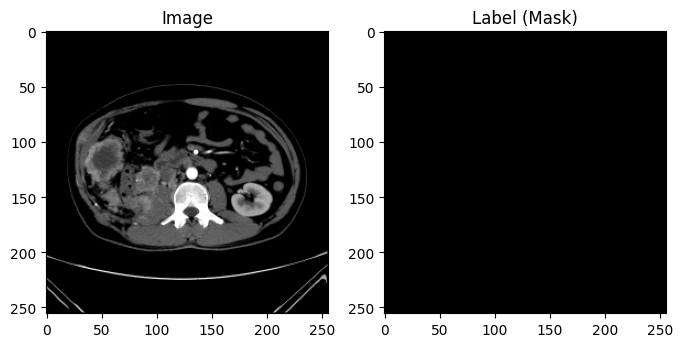

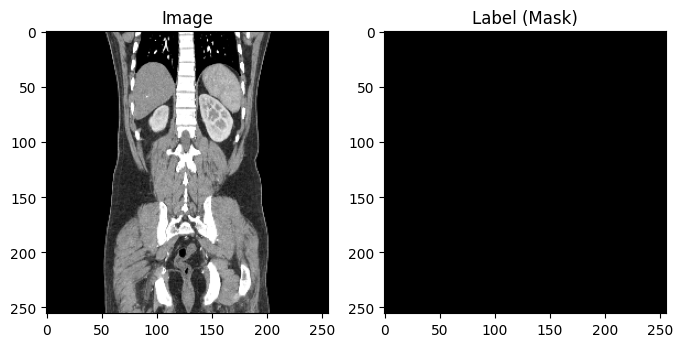

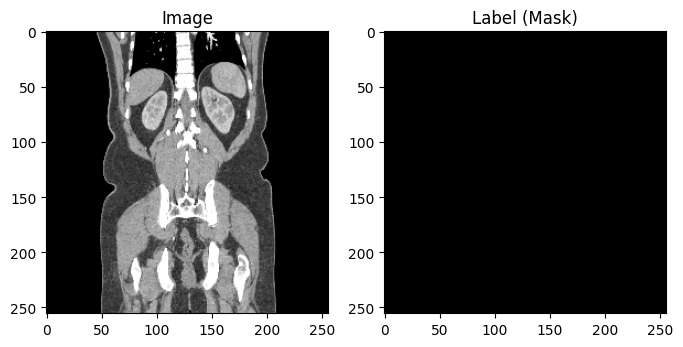

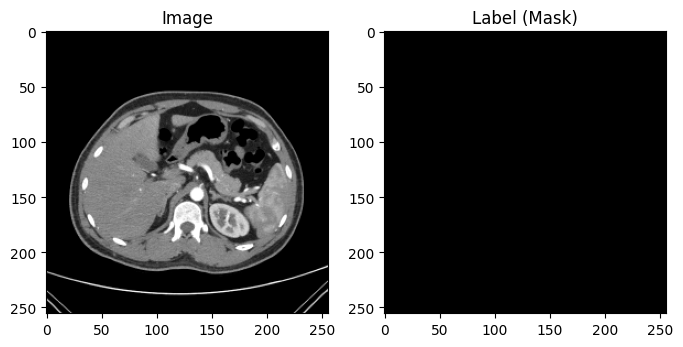

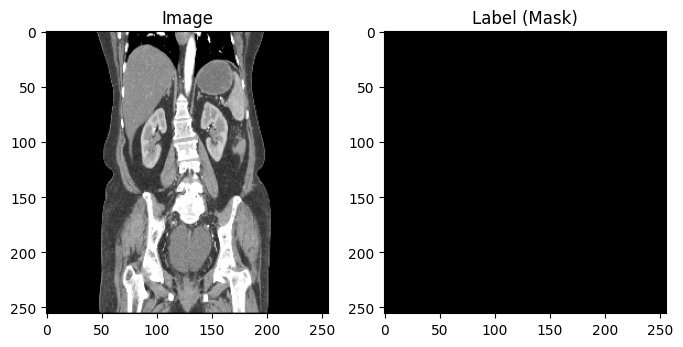

In [ ]:
import random

# Function to display random data with labels
def display_random_data(X, y, num_samples=5):
    indices = random.sample(range(len(X)), num_samples)
    for i in indices:
        plt.figure(figsize=(8, 4))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title('Image')

        # Display the mask (label)
        plt.subplot(1, 2, 2)
        mask = np.argmax(y[i], axis=-1)  # Convert one-hot encoded mask to binary mask
        plt.imshow(mask, cmap='gray')
        plt.title('Label (Mask)')

        plt.show()

# Call the function to display random samples
display_random_data(X, y, num_samples=5)


In [ ]:
# Expand grayscale images to 3 channels
X = np.concatenate([X, X, X], axis=-1)  # Shape becomes (num_samples, 256, 256, 3)


In [ ]:
from tensorflow.keras.layers import Lambda

# Modify the model to accept 1-channel input and convert it to 3-channel internally
def build_vgg16_segmentation_model(input_shape=(256, 256, 1)):
    # Create a custom input and expand to 3 channels
    inputs = Input(shape=input_shape)
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)  # Convert 1-channel to 3-channel

    # Load VGG16 with modified input
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)

    # Freeze VGG16 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Encoder (VGG16 feature extractor)
    vgg_output = base_model.get_layer('block5_conv3').output

    # Decoder (upsampling and convolution layers)
    u1 = UpSampling2D((2, 2))(vgg_output)
    c1 = Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c1 = Conv2D(256, (3, 3), activation='relu', padding='same')(c1)

    u2 = UpSampling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)

    u3 = UpSampling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Build and compile the model
vgg16_model = build_vgg16_segmentation_model(input_shape=(256, 256, 1))
vgg16_model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=16)

# Save the trained model
vgg16_model.save('kidney_ct_segmentation_vgg16_model.h5')



Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1864s 6s/step - accuracy: 0.9988 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 8.7112e-07
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1829s 6s/step - accuracy: 1.0000 - loss: 4.9684e-07 - val_accuracy: 1.0000 - val_loss: 9.2990e-08
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1706s 5s/step - accuracy: 1.0000 - loss: 7.0568e-08 - val_accuracy: 1.0000 - val_loss: 3.0844e-08
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1834s 6s/step - accuracy: 1.0000 - loss: 2.5611e-08 - val_accuracy: 1.0000 - val_loss: 1.5115e-08
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1730s 5s/step - accuracy: 1.0000 - loss: 1.3394e-08 - val_accuracy: 1.0000 - val_loss: 8.9859e-09


In [ ]:
vgg16_model.save('kidney_ct_segmentation_vgg16_model.keras')


In [ ]:
# Visualize some predictions
preds = unet_model.predict(X_test[:5])
for i in range(5):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.argmax(y_test[i], axis=-1), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(np.argmax(preds[i], axis=-1), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()